In [1]:
import os
import time
import collections
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_recall_fscore_support

C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
### READING DATASET ###

# Paths
dataset_path = 'Dataset'
games_dir = next(os.walk(dataset_path))[1]

tag_to_skip = [
    'highlights', 'highlights2', '.DS_Store', '.git', 
    'em_mcs_energy_diff_ascending', 'em_mcs_energy_diff', 'em_mcs_energy']

# Iterating through games
games_data = []
games_path = [os.path.join(dataset_path, g) for g in games_dir]
for path in games_path:
    game_name = os.path.basename(path)
    game_info = os.listdir(path)
    data = collections.OrderedDict()
    for info in game_info:
        tag_name = os.path.splitext(info)[0]
        if tag_name not in tag_to_skip:
            csv_file = os.path.join(path, info)
            if tag_name == 'highlights_boundaries':
                data_value = np.genfromtxt(csv_file, delimiter=',', dtype=None)
            else:
                data_value = np.fromfile(csv_file, sep=' ')
            data[tag_name] = data_value
    data['name'] = game_name
    games_data.append(data)

games_backup = games_data[:]

C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [3]:
### CRIANDO VETOR DE GT ###

wanted_cases = ['Gol', 'Perigo']
to_skip = ['name', 'highlights_boundaries']

for game in games_data:
    h = game['highlights_boundaries']
    end = h[-1][0]
    gt = np.zeros(end)
    for line in h:
        tag = line[2].decode('UTF-8').split(' ')
        name = [t for t in tag if t != ''][-1]
        if name in wanted_cases:
            gt[line[0]-1:line[1]] = 1                   
            
    game['gt'] = gt
    del game['highlights_boundaries']

In [4]:
### CORTANDO VALORES EXCEDENTES PARA QUE TODOS OS DADOS TENHAM O MESMO TAMANHO ###

for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    min_l = min(values)
    for k, v in game.items():
        if len(v) > min_l:
            game[k] = v[:min_l]
            

### ZERO PADDING ###
max_length = 0
for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    max_length = max(values) if max(values)>max_length else max_length

for game in games_data:
    for k, v in game.items():
        if k not in ['name']:
            zero_v = np.zeros(max_length)
            if len(v) < max_length:
                zero_v[:len(v)] = v
                game[k] = zero_v

In [5]:
def get_frames_ids(gt):
    u, counts = np.unique(gt, return_counts=True)
    ind_0 = [i for i, v in enumerate(gt) if v == 0.0]
    ind_1 = [i for i, v in enumerate(gt) if v == 1.0]
    
    ind_0_ids = np.linspace(0, counts[0]-1, counts[1], dtype=int)
    new_ind_0 = [ind_0[j] for j in ind_0_ids]
    
    return sorted(new_ind_0 + ind_1)

In [35]:
def get_matrix(restriction, skip):
    data = []
    gt = []
    for game in games_data:
        if game['name'] in restriction:
            values_array = np.array(list(game.values()))

            # Getting GT
            gt_game = list(values_array[gt_id])

            # Removing name and GT to train
            values_array = np.delete(values_array, (max(name_id, gt_id)), axis=0)
            values_array = np.delete(values_array, (min(name_id, gt_id)), axis=0)    

            frames_ids = get_frames_ids(gt_game)
            gt += [gt_game[i] for i in frames_ids]

            game_features = []
            for feature in values_array:
                # Normalizing
                norm_feature = np.squeeze(normalize([feature], axis=1))
                
                M_feature = np.repeat([norm_feature], f_size, axis=0)
                for i, v in enumerate(skip_values):
                    M_feature[i] = np.roll(M_feature[i], v, axis=0)

                M_feature = M_feature[:, frames_ids]

                M_feature = np.transpose(M_feature)
                if len(game_features) == 0:
                    game_features = M_feature
                else:
                    game_features = np.concatenate((game_features, M_feature), axis=1)

            if len(data) == 0:
                data = game_features
            else:
                data = np.concatenate((data, game_features), axis=0)


    gt = np.array(gt)
    
    return data, gt


In [16]:
### DIVIDING SPLITS FROM TRAIN, EVAL, TEST ###

games_test = ['chi_swi', 'san_vas']
games_train = [g['name'] for g in games_data if g['name'] not in games_test]

print('Total train: {}'.format(len(games_train)))
print('Total test: {}'.format(len(games_test)))

Total train: 28
Total test: 2


In [22]:
for i, tag_name in enumerate(games_data[10].keys()):
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i

skip = 1
f_size = 61
skip_values = np.arange(-30*skip, 31*skip, skip)

X_train, y_train = get_matrix(games_train, skip)

X_test, y_test = get_matrix(games_test, skip)


print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (160674, 976) (160674,)
Test (11082, 976) (11082,)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   43.9s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Average precision-recall score: 0.88
Precision: [0.89507458 0.92851768]
Recall: [0.93142032 0.89081393]
[[5161  380]
 [ 605 4936]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Average precision-recall score: 0.90
Precision: [0.93275014 0.92439678]
Recall: [0.92365999 0.93340552]
[[5118  423]
 [ 369 5172]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.3min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


Average precision-recall score: 0.90
Precision: [0.93497717 0.92473694]
Recall: [0.92384046 0.93575167]
[[5119  422]
 [ 356 5185]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  9.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.3s finished


Average precision-recall score: 0.90
Precision: [0.93517166 0.92508027]
Recall: [0.92420141 0.93593214]
[[5121  420]
 [ 355 5186]]

--------------------------------------------------------------


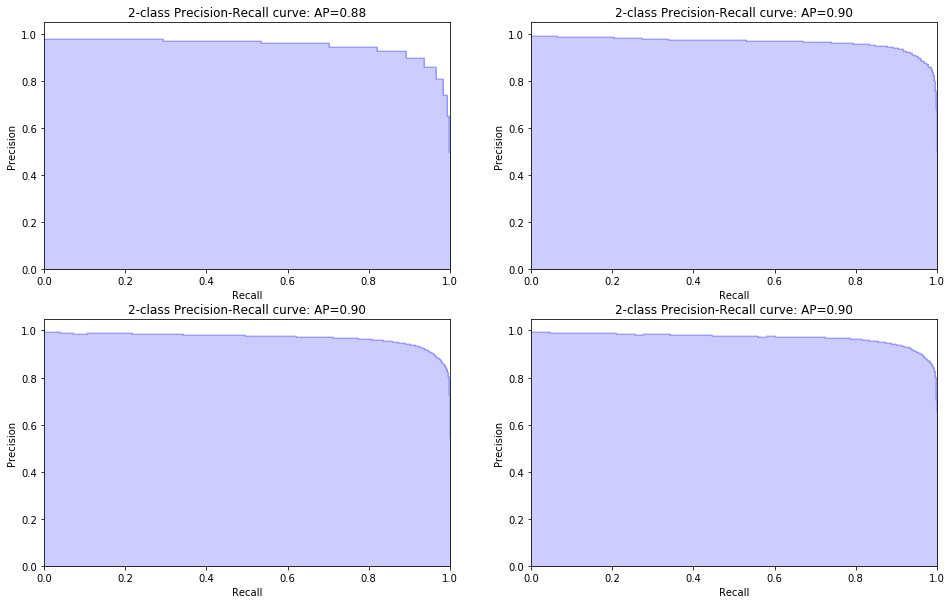

In [26]:
# SKIP = 1 SEM NORMALIZACAO

estimators = [10, 50, 100, 150]
models = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    print('\n--------------------------------------------------------------')
plt.show()

In [27]:
for i, tag_name in enumerate(games_data[10].keys()):
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i

skip = 2
f_size = 61
skip_values = np.arange(-30*skip, 31*skip, skip)

X_train, y_train = get_matrix(games_train, skip)

X_test, y_test = get_matrix(games_test, skip)


print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (160674, 976) (160674,)
Test (11082, 976) (11082,)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Average precision-recall score: 0.87
Precision: [0.8329718  0.96434745]
Recall: [0.97022198 0.80545028]
[[5376  165]
 [1078 4463]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Average precision-recall score: 0.91
Precision: [0.88668321 0.96406591]
Recall: [0.96733442 0.87637611]
[[5360  181]
 [ 685 4856]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Average precision-recall score: 0.91
Precision: [0.89384359 0.96667981]
Recall: [0.96950009 0.88485833]
[[5372  169]
 [ 638 4903]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.2s finished


Average precision-recall score: 0.92
Precision: [0.89817756 0.96686924]
Recall: [0.96950009 0.89009204]
[[5372  169]
 [ 609 4932]]

--------------------------------------------------------------


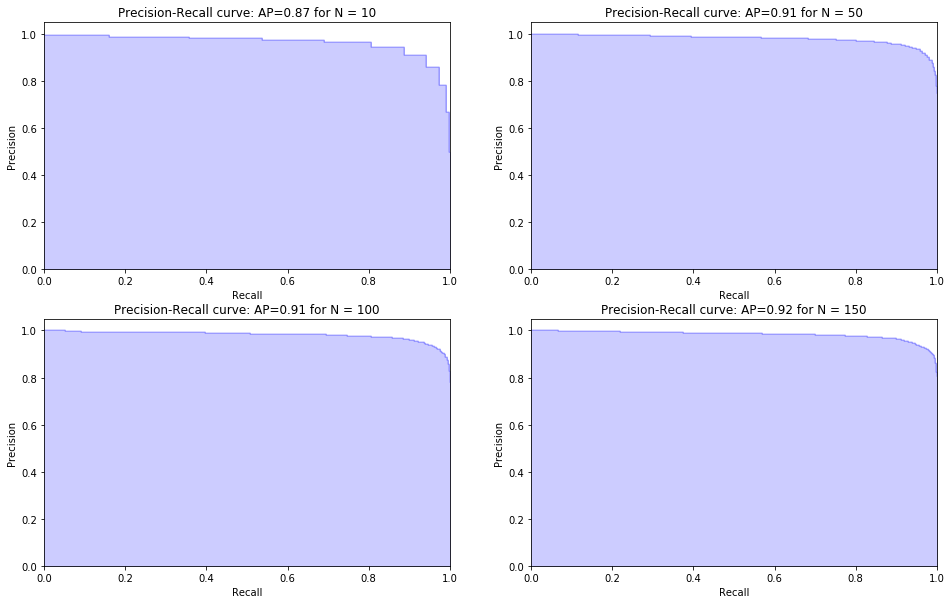

In [28]:
# SKIP = 2 SEM NORMALIZACAO

estimators = [10, 50, 100, 150]
models_s2 = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models_s2.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for N = {}'.format(average_precision, n_est))
    print('\n--------------------------------------------------------------')
plt.show()

In [29]:
for i, tag_name in enumerate(games_data[10].keys()):
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i

skip = 4
f_size = 61
skip_values = np.arange(-30*skip, 31*skip, skip)

X_train, y_train = get_matrix(games_train, skip)

X_test, y_test = get_matrix(games_test, skip)


print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (160674, 976) (160674,)
Test (11082, 976) (11082,)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.5s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Average precision-recall score: 0.85
Precision: [0.79210526 0.97100424]
Recall: [0.97780184 0.74336762]
[[5418  123]
 [1422 4119]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Average precision-recall score: 0.88
Precision: [0.83508501 0.97007806]
Recall: [0.97509475 0.80743548]
[[5403  138]
 [1067 4474]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Average precision-recall score: 0.89
Precision: [0.85040855 0.97265791]
Recall: [0.976719   0.82818986]
[[5412  129]
 [ 952 4589]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.3s finished


Average precision-recall score: 0.89
Precision: [0.85128125 0.97331074]
Recall: [0.97726042 0.82927269]
[[5415  126]
 [ 946 4595]]

--------------------------------------------------------------


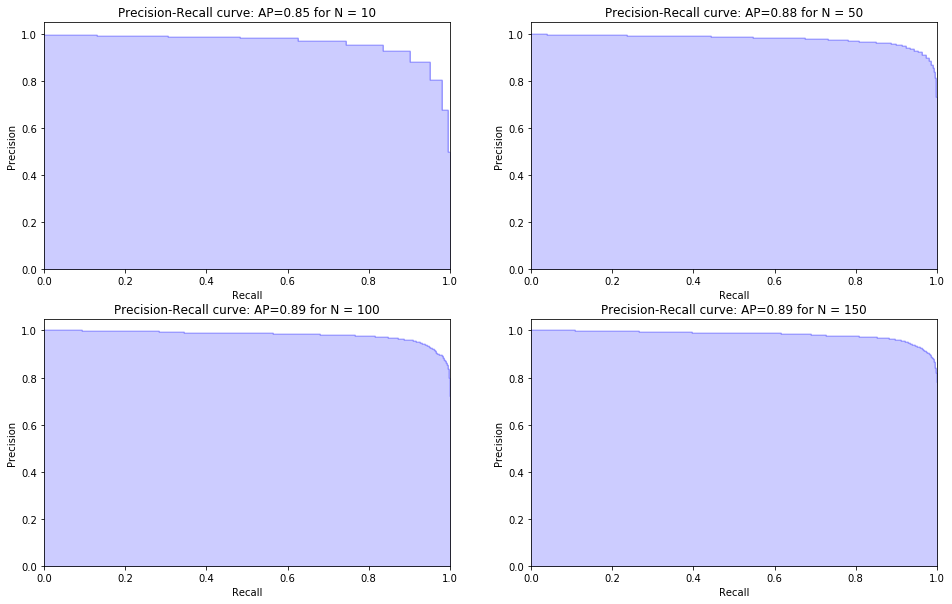

In [30]:
# SKIP = 4 SEM NORMALIZACAO

estimators = [10, 50, 100, 150]
models_s4 = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models_s4.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average pre# SKIP = 4 SEM NORMALIZACAO

estimators = [10, 50, 100, 150]
models_s4 = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models_s4.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for N = {}'.format(average_precision, n_est))
    print('\n--------------------------------------------------------------')
plt.show()cision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for N = {}'.format(average_precision, n_est))
    print('\n--------------------------------------------------------------')
plt.show()

In [31]:
for i, tag_name in enumerate(games_data[10].keys()):
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i

skip = 8
f_size = 61
skip_values = np.arange(-30*skip, 31*skip, skip)

X_train, y_train = get_matrix(games_train, skip)

X_test, y_test = get_matrix(games_test, skip)


print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (160674, 976) (160674,)
Test (11082, 976) (11082,)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Average precision-recall score: 0.81
Precision: [0.73528618 0.97441481]
Recall: [0.98303555 0.64609276]
[[5447   94]
 [1961 3580]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Average precision-recall score: 0.86
Precision: [0.80274013 0.97857476]
Recall: [0.9833965  0.75834687]
[[5449   92]
 [1339 4202]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Average precision-recall score: 0.86
Precision: [0.7982135  0.97883847]
Recall: [0.98375744 0.75130843]
[[5451   90]
 [1378 4163]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.2s finished


Average precision-recall score: 0.86
Precision: [0.797863   0.97882353]
Recall: [0.98375744 0.75076701]
[[5451   90]
 [1381 4160]]

--------------------------------------------------------------


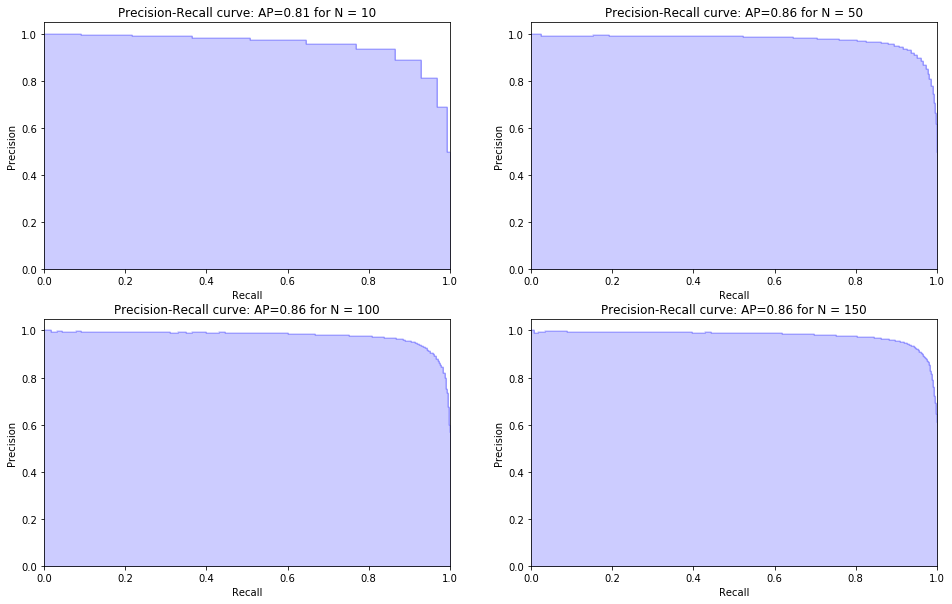

In [32]:
# SKIP = 8 SEM NORMALIZACAO

estimators = [10, 50, 100, 150]
models_s8 = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models_s8.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for N = {}'.format(average_precision, n_est))
    print('\n--------------------------------------------------------------')
plt.show()

In [36]:
for i, tag_name in enumerate(games_data[10].keys()):
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i

skip = 8
f_size = 61
skip_values = np.arange(-30*skip, 31*skip, skip)

X_train, y_train = get_matrix(games_train, skip)

X_test, y_test = get_matrix(games_test, skip)


print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (160674, 976) (160674,)
Test (11082, 976) (11082,)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Average precision-recall score: 0.86
Precision: [0.82765063 0.95170637]
Recall: [0.95939361 0.80021657]
[[5316  225]
 [1107 4434]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Average precision-recall score: 0.89
Precision: [0.86780488 0.95863747]
Recall: [0.96318354 0.85327558]
[[5337  204]
 [ 813 4728]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Average precision-recall score: 0.89
Precision: [0.87588594 0.95473579]
Recall: [0.95903267 0.86410395]
[[5314  227]
 [ 753 4788]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.2s finished


Average precision-recall score: 0.90
Precision: [0.88083416 0.95654762]
Recall: [0.96047645 0.87005956]
[[5322  219]
 [ 720 4821]]

--------------------------------------------------------------


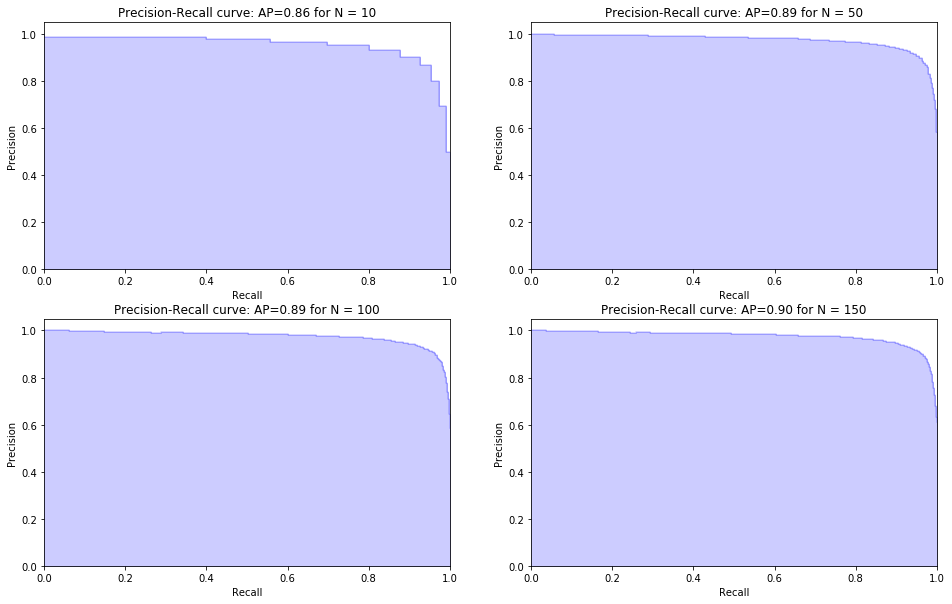

In [37]:
# SKIP = 8 COM NORMALIZACAO

estimators = [10, 50, 100, 150]
models_s8 = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models_s8.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for N = {}'.format(average_precision, n_est))
    print('\n--------------------------------------------------------------')
plt.show()

In [38]:
for i, tag_name in enumerate(games_data[10].keys()):
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i

skip = 4
f_size = 61
skip_values = np.arange(-30*skip, 31*skip, skip)

X_train, y_train = get_matrix(games_train, skip)

X_test, y_test = get_matrix(games_test, skip)


print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (160674, 976) (160674,)
Test (11082, 976) (11082,)


In [ ]:
# SKIP = 4 COM NORMALIZACAO

estimators = [10, 50, 100, 150]
models_s4 = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models_s4.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average pre# SKIP = 4 SEM NORMALIZACAO

estimators = [10, 50, 100, 150]
models_s4 = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models_s4.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for N = {}'.format(average_precision, n_est))
    print('\n--------------------------------------------------------------')
plt.show()cision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for N = {}'.format(average_precision, n_est))
    print('\n--------------------------------------------------------------')
plt.show()